In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    # return -torch.log(-torch.log(U + eps) + eps)
    return torch.log(U)-torch.log(1-U) # + eps) + eps)
def gumbel_softmax(logits, temperature=1.0, hard=False):
    g = sample_gumbel(logits.size())
    y = logits + g.to(logits.device)
    y = y / temperature
    y = F.softmax(y, dim=-1)
    if hard:
        # Straight-through
        max_idx = torch.argmax(y, dim=-1, keepdim=True)
        y_hard = torch.zeros_like(y).scatter_(-1, max_idx, 1.0)
        y = (y_hard - y).detach() + y
    return y
class GumbelBinaryAutoencoder(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, hidden_dim * 2)  # 2 logits per latent dimension
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, input_dim),
            nn.Identity()
        )
    def forward(self, x, temp=1.0, hard=False, ae=False):
        logits = self.encoder(x)
        logits = logits.view(-1, self.hidden_dim, 2)
        if ae == False:
            # z = gumbel_softmax(logits, temperature=temp, hard=hard)
            z = logits + torch.randn_like(logits).to(logits.device)
            z = z.view(-1, self.hidden_dim * 2)
        else:
            z = logits.view(-1, self.hidden_dim * 2)
        return self.decoder(z)

In [2]:
dev = "cuda:4"

In [ ]:
torch.randn_like()

In [11]:
def t_func(n,T0,Tf,N):
    R = 1/N * (T0-Tf)/Tf
    return T0/(1+R*n)

def t_func2(n,T0,Tf,N,om):
    R = 1/N * (T0-Tf)/Tf 
    return T0/(1+R*n) *(1 + (1-1/(n+1)) * np.sin(om*n))

def testing1():
    temp_list, loss_list = [],[]
    input_dim, hidden_dim = 16, 8
    epochs, batch_size, lr = 5000, 1024, 1e-3
    # temperature schedule
    temp_start = 1.0    # start with a higher temperature (more "soft")
    temp_end   = 0.1    # end with a lower temperature (more "discrete")
    # temp_decay = (temp_end / temp_start) ** (1.0 / (epochs - 1))
    epoch_start = 0
    rate = 1/(epochs-epoch_start) * (temp_start - temp_end)/temp_end
    DS = 2000
    # X = torch.rand(1000, input_dim)
    X = torch.cos(torch.arange(0,6.5,6.5/16)*2).unsqueeze(0).repeat(DS,1) + torch.randn(DS,input_dim)*0.25
    data_loader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True)
    model = GumbelBinaryAutoencoder(input_dim, hidden_dim)
    model = model.to(dev)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    temp = temp_start
    for epoch in range(epochs):
        total_loss = 0
        for i,batch in enumerate(data_loader):
            batch = batch.to(dev)
            out = model(batch, temp=temp, hard=False, ae=False)
            loss = criterion(out, batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(batch)
            
            temp = t_func2(epoch*len(data_loader) + i ,temp_start,temp_end,(epochs-epoch_start)*len(data_loader),0.0)
            temp_list.append(temp)
            loss_list.append(loss.item())
        
        avg_loss = total_loss / len(X)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Temp: {temp:.3f}, Loss: {avg_loss:.6f}")
        
        
        # Anneal temperature
        # if epoch > epoch_start:
        # temp = max(temp_end, temp * temp_decay)
            # temp = temp_start/(1+rate*epoch)
            # temp = t_func2(epoch,temp_start,temp_end,epochs-epoch_start,0.1)
    # Quick test
    with torch.no_grad():
        test_samples = X[:5].to(dev)
        reconstructed = model(test_samples, temp=1.0, hard=True)
        print("Original:\n", test_samples)
        print("Reconstructed:\n", reconstructed)
    return test_samples, reconstructed, temp_list, loss_list

In [15]:
test_samples, reconstructed, temp_list, loss_list = testing1()

Epoch [1/5000], Temp: 0.999, Loss: 0.577819
Epoch [101/5000], Temp: 0.847, Loss: 0.062465
Epoch [201/5000], Temp: 0.735, Loss: 0.059441
Epoch [301/5000], Temp: 0.649, Loss: 0.058912
Epoch [401/5000], Temp: 0.581, Loss: 0.056864
Epoch [501/5000], Temp: 0.526, Loss: 0.055303
Epoch [601/5000], Temp: 0.481, Loss: 0.052713
Epoch [701/5000], Temp: 0.442, Loss: 0.049344
Epoch [801/5000], Temp: 0.410, Loss: 0.045706
Epoch [901/5000], Temp: 0.382, Loss: 0.042953
Epoch [1001/5000], Temp: 0.357, Loss: 0.042490
Epoch [1101/5000], Temp: 0.335, Loss: 0.042247
Epoch [1201/5000], Temp: 0.316, Loss: 0.040772
Epoch [1301/5000], Temp: 0.299, Loss: 0.036523
Epoch [1401/5000], Temp: 0.284, Loss: 0.034163
Epoch [1501/5000], Temp: 0.270, Loss: 0.031422
Epoch [1601/5000], Temp: 0.258, Loss: 0.030957
Epoch [1701/5000], Temp: 0.246, Loss: 0.030658
Epoch [1801/5000], Temp: 0.236, Loss: 0.030366
Epoch [1901/5000], Temp: 0.226, Loss: 0.030247
Epoch [2001/5000], Temp: 0.217, Loss: 0.028273
Epoch [2101/5000], Temp: 

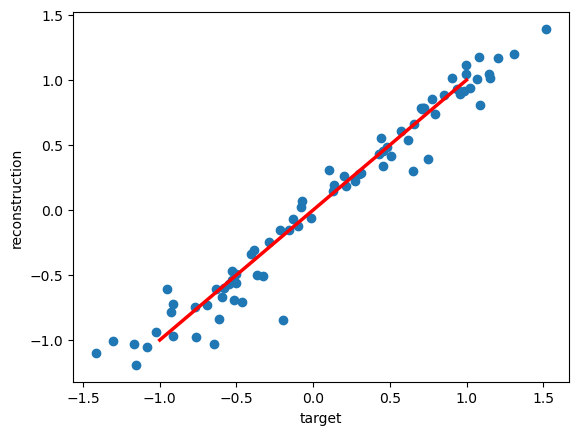

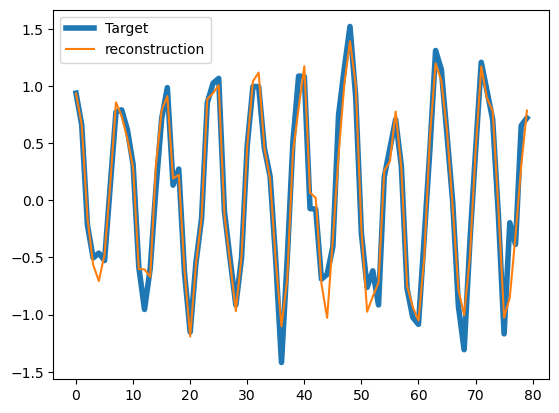

In [16]:
plt.scatter(test_samples.view(-1).detach().cpu(),reconstructed.view(-1).detach().cpu())
plt.xlabel("target")
plt.ylabel("reconstruction")
plt.plot([-1,1],[-1,1], c='red', lw=2.5)
plt.show()
plt.plot(test_samples.view(-1).detach().cpu(), lw=4)
plt.plot(reconstructed.view(-1).detach().cpu())
plt.legend(["Target", "reconstruction"])
plt.show()


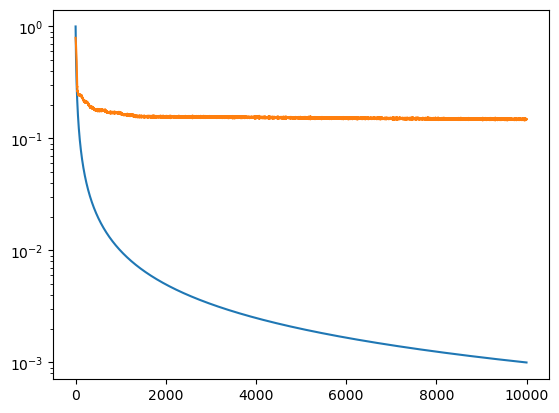

In [24]:
plt.plot(np.array(temp_list)/100)
plt.plot(loss_list)
plt.yscale('log')
# plt.xscale('log')
plt.show()

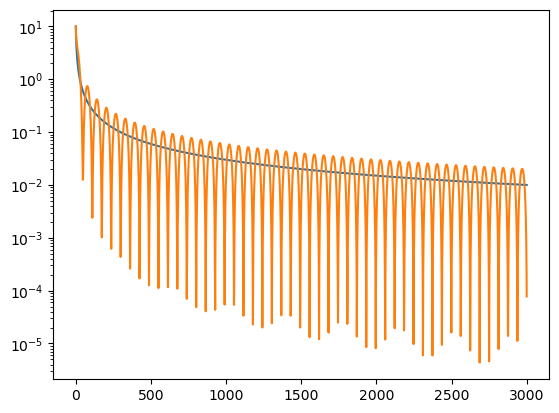

In [6]:
N=3000
plt.plot([t_func(i,10,0.01,N) for i in range(N)])
plt.plot([t_func2(i,10,0.01,N,0.1) for i in range(N)])
plt.yscale('log')

In [335]:
xx = torch.rand(10).to(dev)

In [339]:
torch.rand(10).to(xx.device)

tensor([0.0108, 0.1769, 0.1206, 0.3142, 0.2977, 0.0644, 0.6534, 0.1420, 0.6825,
        0.5287], device='cuda:4')

In [363]:
X = torch.cos(torch.arange(0,6.5,6.5/16)*2).unsqueeze(0).repeat(1000,1) + torch.randn(1000,16)*0.5
data_loader = torch.utils.data.DataLoader(X, batch_size=512, shuffle=True)

In [364]:
len(data_loader)

2

In [378]:
1000/32

31.25